# Tutorial: Running DVC stages with EncFS and Docker 

This guide demonstrates how to configure app-policies for the application to be run in a Docker container operating on encrypted data managed through EncFS. To learn about the steps to construct a DVC repository with infrastructure-as-code techniques please refer to the [tutorial for an ML repository](ml_tutorial.ipynb). Our example application will perform an iterative simulation with a linear data dependency graph. The key steps we will cover include:

 * Initialize a DVC repository to be managed by EncFS
 * Configure an app policy to use Docker in a DVC stage
 * Run a DVC stage using Docker and EncFS and inspect the results through a manually mounted encrypted filesystem

It is important to note that while we use Docker here, the container engine [Sarus](https://products.cscs.ch/sarus/) is equally supported and extensions for others are possible as well.

As a prerequisite to this tutorial, you should have `encfs` installed as described in the [instructions](../async_encfs_dvc/encfs_int/README.md).

## Initializing the DVC repository
We first import the depencies for the tutorial.

In [1]:
import os

In [2]:
from IPython.display import SVG  # test_encfs_sim_tutorial: skip

Create a new directory `data/v1` for the DVC root and change to it.

In [3]:
os.chdir('data/v1')

Initialize an `encfs` DVC repository using the command

In [4]:
!dvc_init_repo . encfs

2023-07-31 11:47:00,913 DEBUG: v0.1.dev8866+gd72e04c, CPython 3.8.10 on Linux-5.15.0-78-generic-x86_64-with-glibc2.29
2023-07-31 11:47:00,914 DEBUG: command: /home/lukasd/src/mitraccel/async-encfs-dvc/venv/bin/dvc init --subdir --verbose
2023-07-31 11:47:01,421 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvc/config.local' to gitignore file.
2023-07-31 11:47:01,422 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvc/tmp' to gitignore file.
2023-07-31 11:47:01,422 DEBUG: Added '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvc/cache' to gitignore file.
2023-07-31 11:47:01,423 DEBUG: Removing '/var/tmp/dvc/repo/a177a6927f8a74db68a8839474eacc3f'
2023-07-31 11:47:01,454 DEBUG: Staging files: {'/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvc/config', '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvcignore', '/home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/.dvc/.gitignore'}
In

As next step, EncFS needs to be configured, which can be achieved by running

```shell
${ENCFS_INSTALL_DIR}/bin/encfs -o allow_root,max_write=1048576,big_writes -f encrypt decrypt
```
as described in the [EncFS initialization instructions](../async_encfs_dvc/encfs_int/README.md).

Here, only for the purpose of this tutorial, we use a pre-established configuration with a simple password. It is important that this is only for demonstration purposes - in practice always generate a **random** key and store it in a **safe location**!

In [5]:
%%bash
echo 1234 > encfs_tutorial.key
cp $(git rev-parse --show-toplevel)/examples/.encfs6.xml.tutorial encrypt/ && mv encrypt/.encfs6.xml.tutorial encrypt/.encfs6.xml

At runtime, EncFS will read the password from a file. The location of that file is passed in an environment variable that has to be set when `dvc repro` is run on a stage or `encfs_launch` is used to e.g. inspect the encrypted data interactively.

In [6]:
os.environ['ENCFS_PW_FILE'] = os.path.realpath('encfs_tutorial.key')

The DVC repo has been initialized with repo and stage policies available under `.dvc_policies`.

In [7]:
!tree .dvc_policies

.dvc_policies
├── repo
│   └── dvc_root.yaml
└── stages
    ├── dvc_config.yaml
    ├── dvc_etl.yaml
    ├── dvc_in.yaml
    ├── dvc_ml_inference.yaml
    ├── dvc_ml_training.yaml
    └── dvc_simulation.yaml

2 directories, 7 files


For the purpose of this tutorial, we will extract the paths of the encrypted directory and the mount target of EncFS into environment variables. This is not a necessary step to run DVC stages with EncFS, though.

In [8]:
from async_encfs_dvc.encfs_int.mount_config import load_mount_config

mount_config = [os.popen(f"echo {d}").read().strip() for d in  # evaluating shell exprs in paths
                load_mount_config('.dvc_policies/repo/dvc_root.yaml')]

os.environ['ENCFS_ENCRYPT_DIR'] = mount_config[0]  # encrypt (same on all hosts)
os.environ['ENCFS_DECRYPT_DIR'] = mount_config[1]  # host-specific

## Establishing the input dataset
Our pipeline will be based on a dataset labeled `sim_dataset_v1` and thereof a specific subset `ex2` (label chosen arbitrarily). First, we create a DVC stage to track the encrypted input data. As `dvc add` on longer supports the `--file` option to locate the `.dvc` file in a different folder, we use a workaround with a frozen no-op stage analogous to the manual preprocessing step for the training dataset in the ML tutorial.

In [9]:
!dvc_create_stage --app-yaml ../../in/dvc_app.yaml --stage add --run-label init --dataset-name sim_dataset_v1 --subset-name ex2

Not using SLURM or MPI in this DVC stage.
Writing DVC stage to config/in/sim_dataset_v1/original/ex2
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.
Added stage 'in_original_add_init' in 'dvc.yaml'                      core>

To track the changes with git, run:

	git add .gitignore ../../../../../encrypt/in/sim_dataset_v1/original/ex2/.gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Freezing stage for execution outside dvc - run 'dvc commit in_original_add_init' when outputs are done.
Modifying stage 'in_original_add_init' in 'dvc.yaml'                  core>


In [10]:
!cat config/in/sim_dataset_v1/original/ex2/dvc.yaml

stages:
  in_original_add_init:
    desc: Generated with venv/bin/dvc_create_stage --app-yaml ../../in/dvc_app.yaml
      --stage add --run-label init --dataset-name sim_dataset_v1 --subset-name ex2
      at commit 6535c7d6d7e8986037b68ac6516f460aeb53e26b
    cmd: 'dvc_cmd in_original_add_init encfs_mount_and_run ../../../../../encrypt
      ../../../../../decrypt_in_original_add_init_12d6bb635683_3497ddc9be6b ../../../../../decrypt_in_original_add_init_12d6bb635683_3497ddc9be6b/in/sim_dataset_v1/original/ex2/output/encfs_out_{MPI_RANK}.log
      bash -c "true --in-output ../../../../../decrypt_in_original_add_init_12d6bb635683_3497ddc9be6b/in/sim_dataset_v1/original/ex2/output" '
    outs:
    - ../../../../../encrypt/in/sim_dataset_v1/original/ex2/output
    - output
    frozen: true


We now populate this dataset repository with input data that we generate randomly here, even though it could be downloaded from a remote source. As this will be encrypted data, we have to run `dd` that generates this data in an environment managed by EncFS, which is achieved by wrapping the command with `encfs_mount_and_run`. 

In [11]:
%%bash
encfs_mount_and_run encrypt ${ENCFS_DECRYPT_DIR} ${ENCFS_DECRYPT_DIR}/in/sim_dataset_v1/original/ex2/output/encfs_out.log \
    dd if=/dev/urandom of=${ENCFS_DECRYPT_DIR}/in/sim_dataset_v1/original/ex2/output/sim_in.dat bs=4k iflag=fullblock,count_bytes count=$((10**7)) \
    > config/in/sim_dataset_v1/original/ex2/output/dvc_stage_out.log

We can inspect the logs of the outer command, that is of `encfs_mount_and_run`, which we capture in the file `dvc_stage_out.log`.

In [12]:
!cat config/in/sim_dataset_v1/original/ex2/output/dvc_stage_out.log

encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: Unable to determine local MPI rank - assuming to run in non-distributed mode (as a single process).
encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: Rank 0 on ThinkPad-X1: Running encfs-mount at /home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/decrypt_3497ddc9be6b.
encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: total 4.0K
drwxrwxr-x 3 lukasd lukasd 4.0K Jul 31 11:47 in
encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: Rank 0 on ThinkPad-X1: Successfully mounted encfs-dir at /home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/decrypt_3497ddc9be6b and wrote to sync-file /home/lukasd/src/mitraccel/async-encfs-dvc/examples/data/v1/encrypt/.decrypt_3497ddc9be6b_ThinkPad-X1_local_sync - starting encfs-job
encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: Rank 0 on ThinkPad-X1: encfs-job completed.
encfs_mount_and_run[encrypt->decrypt_3497ddc9be6b]: Rank 0 on ThinkPad-X1: sync-file content is 0 - entering wait-

These logs are unencrypted and do not leak any details on the application inside the EncFS-environment. The application logs are captured separately in the encrypted file `encfs_out.log`. To inspect it, we need to mount a decrypted view of `encrypt`. In a typical session, a user would launch EncFS in the foreground on a another terminal using
```shell
encfs_launch
```
and then access the decrypted data here. However, *exclusively* for the purpose of this notebook, we will copy the decrypted data to an unencrypted location to inspect it outside of EncFS. We emphasize that this is only for demonstration purposes and confidential data should *never* be handled in that manner.

In [13]:
%%bash
encfs_mount_and_run encrypt ${ENCFS_DECRYPT_DIR} /dev/null cp ${ENCFS_DECRYPT_DIR}/in/sim_dataset_v1/original/ex2/output/encfs_out.log encfs_out.log >/dev/null
cat encfs_out.log
rm encfs_out.log

2441+1 records in
2441+1 records out
10000000 bytes (10 MB, 9.5 MiB) copied, 0.171129 s, 58.4 MB/s


To avoid logging the output of an EncFS-managed application to a file, you can supply `/dev/null` as a third parameter to `encfs_mount_and_run` as done here.

Finally, we commit the newly added data to DVC as described in the manual preprocessing step for the training dataset in the ML tutorial.

In [14]:
!dvc commit --force config/in/sim_dataset_v1/original/ex2/dvc.yaml 

Generating lock file 'config/in/sim_dataset_v1/original/ex2/dvc.lock'           
Updating lock file 'config/in/sim_dataset_v1/original/ex2/dvc.lock'


The resulting file hierarchy looks as follows:

In [15]:
!tree encrypt config

encrypt
└── in
    └── sim_dataset_v1
        └── original
            └── ex2
                └── output
                    ├── encfs_out.log
                    └── sim_in.dat
config
└── in
    └── sim_dataset_v1
        └── original
            └── ex2
                ├── dvc_app.yaml
                ├── dvc.lock
                ├── dvc.yaml
                └── output
                    └── dvc_stage_out.log

10 directories, 6 files


Before moving to the definition of preprocessing stages, we define execution labels based on timestamps for the subsequent DVC stages. In a real-world application, the timestamps would usually be generated on the fly when creating the DVC stage.

In [16]:
%env ETL_RUN_LABEL=ex2-20230714-083624
%env SIM_0_RUN_LABEL=ex2-20230714-083812-0
%env SIM_1_RUN_LABEL=ex2-20230714-083812-1
%env SIM_2_RUN_LABEL=ex2-20230714-083812-2
%env SIM_3_RUN_LABEL=ex2-20230714-083812-3

env: ETL_RUN_LABEL=ex2-20230714-083624
env: SIM_0_RUN_LABEL=ex2-20230714-083812-0
env: SIM_1_RUN_LABEL=ex2-20230714-083812-1
env: SIM_2_RUN_LABEL=ex2-20230714-083812-2
env: SIM_3_RUN_LABEL=ex2-20230714-083812-3


## Constructing the preprocessing stage
The next step involves setting up the preprocessing stage. For illustration purposes, we will use the same preprocessing application as in the ML repository tutorial.

In [17]:
!dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml --stage sim \
    --run-label ${ETL_RUN_LABEL} --input-etl ex2 --input-etl-file output/sim_in.dat

Not using SLURM or MPI in this DVC stage.
Writing DVC stage to config/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.
Added stage 'app_prep_v1_sim_ex2-20230714-083624' in 'dvc.yaml'       core>

To track the changes with git, run:

	git add .gitignore dvc.yaml ../../../../../../encrypt/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/.gitignore

To enable auto staging, run:

	dvc config core.autostage true


In [18]:
!cat config/in/sim_dataset_v1/app_prep_v1/auto/${ETL_RUN_LABEL}/dvc.yaml

stages:
  app_prep_v1_sim_ex2-20230714-083624:
    desc: Generated with venv/bin/dvc_create_stage --app-yaml ../../app_prep/dvc_app.yaml
      --stage sim --run-label ex2-20230714-083624 --input-etl ex2 --input-etl-file
      output/sim_in.dat at commit 6535c7d6d7e8986037b68ac6516f460aeb53e26b
    cmd: 'dvc_cmd app_prep_v1_sim_ex2-20230714-083624 encfs_mount_and_run ../../../../../../encrypt
      ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b
      ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/output/encfs_out_{MPI_RANK}.log
      bash -c "$(git rev-parse --show-toplevel)/examples/app_prep/prep.sh --etl-input
      ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b/in/sim_dataset_v1/original/ex2/output/sim_in.dat
      --etl-output ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc

In [19]:
!dvc repro config/in/sim_dataset_v1/app_prep_v1/auto/${ETL_RUN_LABEL}/dvc.yaml

Stage 'config/in/sim_dataset_v1/original/ex2/dvc.yaml:in_original_add_init' didn't change, skipping
Running stage 'config/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/dvc.yaml:app_prep_v1_sim_ex2-20230714-083624':
> dvc_cmd app_prep_v1_sim_ex2-20230714-083624 encfs_mount_and_run ../../../../../../encrypt ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/output/encfs_out_{MPI_RANK}.log bash -c "$(git rev-parse --show-toplevel)/examples/app_prep/prep.sh --etl-input ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b/in/sim_dataset_v1/original/ex2/output/sim_in.dat --etl-output ../../../../../../decrypt_app_prep_v1_sim_ex2-20230714-083624_1d604493207b_3497ddc9be6b/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/output" 
encfs_mount_and_run[../../../../../../e

Execution can also be deferred to the simulation stages, where it will be triggered as a dependency.

## Creating the simulation stages
Lastly, we will establish a rudimentary structure for an iterative simulation workflow that utilizes the preprocessed data. A usual simulation comes with its own tunable parameters. For this purpose, one can use a file such as for hyperparameters in the machine learning tutorial. However, for brevity here we skip this step and assume that all parameters are passed through the command line.

We are now ready to set up the simulation stages. Where necessary, we can obtain completion suggestions with `--show-opts`.

In [20]:
%%bash
dvc_create_stage --app-yaml ../../app_sim/dvc_app_docker.yaml --stage base_simulation \
  --run-label ${SIM_0_RUN_LABEL} \
  --input-simulation ${ETL_RUN_LABEL} \
  --simulation-output-file-num-per-rank 3 \
  --simulation-output-file-size $((10**6 * 2**0 / 3))

Added stage 'app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0' in 'dvc.yaml'

To track the changes with git, run:

	git add dvc.yaml ../../../../../encrypt/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/.gitignore .gitignore

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.


The `dvc.yaml` file takes the form

In [21]:
!cat config/app_sim_v1/sim_dataset_v1/simulation/${SIM_0_RUN_LABEL}/dvc.yaml

stages:
  app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0:
    desc: Generated with venv/bin/dvc_create_stage --app-yaml ../../app_sim/dvc_app_docker.yaml
      --stage base_simulation --run-label ex2-20230714-083812-0 --input-simulation
      ex2-20230714-083624 --simulation-output-file-num-per-rank 3 --simulation-output-file-size
      333333 at commit 6535c7d6d7e8986037b68ac6516f460aeb53e26b
    cmd: 'dvc_cmd app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0
      encfs_mount_and_run ../../../../../encrypt ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1281c_3497ddc9be6b
      ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1281c_3497ddc9be6b/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/output/encfs_out_{MPI_RANK}.log
      docker run --rm -v "$(realpath ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1

In [22]:
%%bash
dvc_create_stage --app-yaml ../../app_sim/dvc_app_docker.yaml --stage simulation \
  --run-label ${SIM_1_RUN_LABEL} \
  --input-simulation ${SIM_0_RUN_LABEL} \
  --simulation-output-file-num-per-rank 3 \
  --simulation-output-file-size $((10**6 * 2**1 / 3))

Added stage 'app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-1' in 'dvc.yaml'

To track the changes with git, run:

	git add ../../../../../encrypt/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-1/.gitignore .gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-1
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.


In [23]:
%%bash
dvc_create_stage --app-yaml ../../app_sim/dvc_app_docker.yaml --stage simulation \
  --run-label ${SIM_2_RUN_LABEL} \
  --input-simulation ${SIM_1_RUN_LABEL} \
  --simulation-output-file-num-per-rank 3 \
  --simulation-output-file-size $((10**6 * 2**2 / 3))

Added stage 'app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-2' in 'dvc.yaml'

To track the changes with git, run:

	git add .gitignore dvc.yaml ../../../../../encrypt/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-2/.gitignore

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-2
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.


In [24]:
%%bash
dvc_create_stage --app-yaml ../../app_sim/dvc_app_docker.yaml --stage simulation \
  --run-label ${SIM_3_RUN_LABEL} \
  --input-simulation ${SIM_2_RUN_LABEL} \
  --simulation-output-file-num-per-rank 3 \
  --simulation-output-file-size $((10**6 * 2**3 / 3))

Added stage 'app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-3' in 'dvc.yaml'

To track the changes with git, run:

	git add .gitignore ../../../../../encrypt/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-3/.gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true
Writing DVC stage to config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-3
Using encfs - don't forget to set ENCFS_PW_FILE/ENCFS_INSTALL_DIR when running 'dvc repro'.


In [25]:
!tree encrypt config

encrypt
├── app_sim_v1
│   └── sim_dataset_v1
│       └── simulation
│           ├── ex2-20230714-083812-0
│           │   └── output
│           ├── ex2-20230714-083812-1
│           │   └── output
│           ├── ex2-20230714-083812-2
│           │   └── output
│           └── ex2-20230714-083812-3
│               └── output
└── in
    └── sim_dataset_v1
        ├── app_prep_v1
        │   └── auto
        │       └── ex2-20230714-083624
        │           └── output
        │               ├── encfs_out_0.log
        │               └── sim_in.dat
        └── original
            └── ex2
                └── output
                    ├── encfs_out.log
                    └── sim_in.dat
config
├── app_sim_v1
│   └── sim_dataset_v1
│       └── simulation
│           ├── ex2-20230714-083812-0
│           │   ├── dvc_app_docker.yaml
│           │   ├── dvc.yaml
│           │   └── output
│           ├── ex2-20230714-083812-1
│           │   ├── dvc_app_docker.yaml
│           │   ├── d

## Running the pipeline
The stages can be inspected with:

In [26]:
%%bash
dvc dag --dot config/app_sim_v1/sim_dataset_v1/simulation/${SIM_3_RUN_LABEL}/dvc.yaml | tee config/app_sim_v1/sim_dataset_v1/simulation/${SIM_3_RUN_LABEL}/dvc_dag.dot
if [[ $(command -v dot) ]]; then
    dot -Tsvg config/app_sim_v1/sim_dataset_v1/simulation/${SIM_3_RUN_LABEL}/dvc_dag.dot > config/app_sim_v1/sim_dataset_v1/simulation/${SIM_3_RUN_LABEL}/dvc_dag.svg
fi

strict digraph  {
"config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/dvc.yaml:app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0";
"config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-2/dvc.yaml:app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-2";
"config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-3/dvc.yaml:app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-3";
"config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-1/dvc.yaml:app_sim_v1_sim_dataset_v1_simulation_ex2-20230714-083812-1";
"config/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/dvc.yaml:app_prep_v1_sim_ex2-20230714-083624";
"config/in/sim_dataset_v1/original/ex2/dvc.yaml:in_original_add_init";
"config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/dvc.yaml:app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0" -> "config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-1/dvc.yaml:app_sim_v1_sim_dataset_v1_si

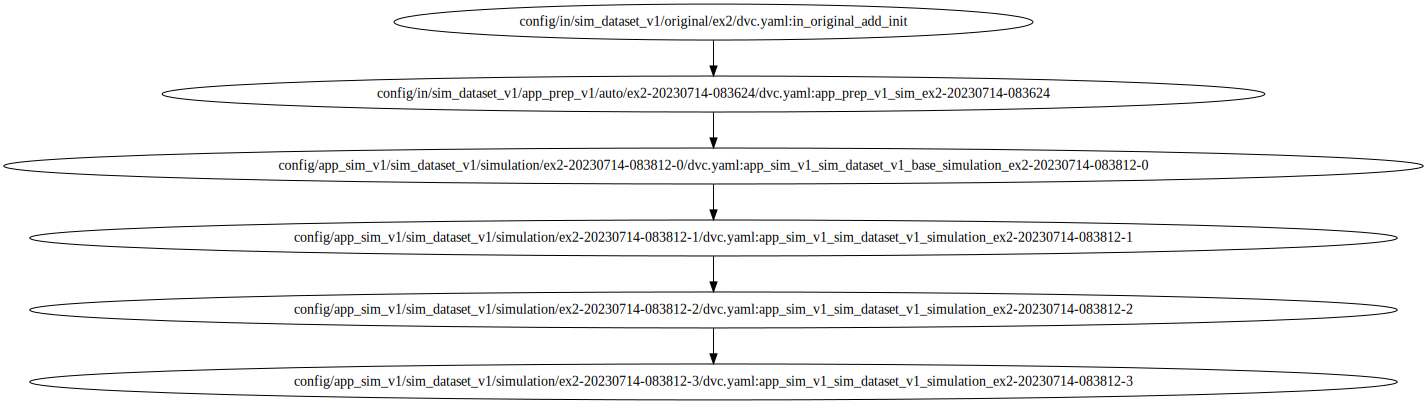

In [27]:
dvc_dag_img = 'config/app_sim_v1/sim_dataset_v1/simulation/' + os.environ['SIM_3_RUN_LABEL'] + '/dvc_dag.svg'  # test_encfs_sim_tutorial: skip
if os.path.exists(dvc_dag_img):  # test_encfs_sim_tutorial: skip
    display(SVG(filename=dvc_dag_img))  # test_encfs_sim_tutorial: skip

And finally executed with:

In [28]:
!dvc repro config/app_sim_v1/sim_dataset_v1/simulation/${SIM_3_RUN_LABEL}/dvc.yaml

Stage 'config/in/sim_dataset_v1/original/ex2/dvc.yaml:in_original_add_init' didn't change, skipping
Stage 'config/in/sim_dataset_v1/app_prep_v1/auto/ex2-20230714-083624/dvc.yaml:app_prep_v1_sim_ex2-20230714-083624' didn't change, skipping
Running stage 'config/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/dvc.yaml:app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0':
> dvc_cmd app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0 encfs_mount_and_run ../../../../../encrypt ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1281c_3497ddc9be6b ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1281c_3497ddc9be6b/app_sim_v1/sim_dataset_v1/simulation/ex2-20230714-083812-0/output/encfs_out_{MPI_RANK}.log docker run --rm -v "$(realpath ../../../../../decrypt_app_sim_v1_sim_dataset_v1_base_simulation_ex2-20230714-083812-0_b8eaaec1281c_3497ddc9be6b)":"/app-data"  --entrypoint

As described above, results can be inspected by running EncFS with `encfs_launch .dvc_policies/repo/dvc_root.yaml` from the DVC root directory in another terminal and then accessing the data through the `decrypt` directory.

In [29]:
!tree encrypt config

encrypt
├── app_sim_v1
│   └── sim_dataset_v1
│       └── simulation
│           ├── ex2-20230714-083812-0
│           │   └── output
│           │       ├── encfs_out_0.log
│           │       ├── sim.0.0.dat
│           │       ├── sim.0.1.dat
│           │       ├── sim.0.2.dat
│           │       ├── sim.1.0.dat
│           │       ├── sim.1.1.dat
│           │       └── sim.1.2.dat
│           ├── ex2-20230714-083812-1
│           │   └── output
│           │       ├── encfs_out_0.log
│           │       ├── sim.0.0.dat
│           │       ├── sim.0.1.dat
│           │       ├── sim.0.2.dat
│           │       ├── sim.1.0.dat
│           │       ├── sim.1.1.dat
│           │       └── sim.1.2.dat
│           ├── ex2-20230714-083812-2
│           │   └── output
│           │       ├── encfs_out_0.log
│           │       ├── sim.0.0.dat
│           │       ├── sim.0.1.dat
│           │       ├── sim.0.2.dat
│           │       ├── sim.1.0.dat
│           │       ├── sim.1.1.dat
│   